In [12]:

import os
from dotenv import load_dotenv
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_ollama import ChatOllama, OllamaLLM, OllamaEmbeddings
load_dotenv()
# deepseek-r1:32b ｜ qwq:32b
chat_model = ChatOllama(
    base_url=os.environ['OLLAMA_BASE_URL'],  # 可配置为内部服务器地址
    model="deepseek-r1:32b",
    temperature=0.8,
    num_ctx=4096  # 上下文窗口大小
)
# 2.加载模型
embedding_model = OllamaEmbeddings(
    base_url=os.environ['OLLAMA_BASE_URL'],  # 可配置为内部服务器地址
    model=os.environ['OLLAMA_EMBEDDING_MODEL_NAME'],
    temperature=0.8,
    num_ctx=4096  # 上下文窗口大小
)
llm_model = OllamaLLM(
    base_url=os.environ['OLLAMA_BASE_URL'],  # 可配置为内部服务器地址
    model="qllama/bge-reranker-large:latest",
    temperature=0.2, # 控制随机性（0 确定性高，1 创造性高）。
    num_ctx=4096,  # 上下文窗口大小
    top_p=0.8, #核采样概率，过滤低概率 token（0.1 严格，1.0 宽松）。
    )

# messages = [
#     SystemMessage(content="你是一个助手，用简体中文回答。"),
#     HumanMessage(content="推荐一本关于AI的书籍。")
# ]
# response = model.invoke(messages)
# print(response.content)  # 输出结构化消息
# for chunk in model.stream(messages):
#     print(chunk.content, end="", flush=True)





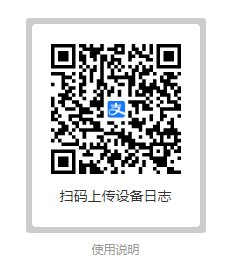

In [27]:
from langchain_core.messages import HumanMessage
import base64

def image_to_base64(image_path):
    try:
        # 打开指定路径的图像文件，以二进制读取模式("rb")
        with open(image_path, "rb") as img_file:
            # 使用base64库将图像文件内容编码为base64字符串
            return base64.b64encode(img_file.read()).decode("utf-8")
    except FileNotFoundError:
            print(f"文件 {image_path} 未找到。")
            return None

image_b64 = image_to_base64("../files/image.png")
message = HumanMessage(content=[
    {"type": "text", "text": "描述这张图片"},
    {"type": "image_url", "image_url": f"data:image/png;base64,{image_b64}"}
])
print(f"data:image/png;base64,{image_b64}")
# 需要视觉大模型识别
# response = model.invoke([message])
# print(response)

In [14]:
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_template("""
    根据用户输入判断意图类别，仅返回分类标签。
    可选标签：查询信息、操作指令、闲聊、其他。
    输入：{user_input}
    分类结果：
    """)
chain = prompt | llm_model
response = chain.invoke({"user_input": "帮我订明天的机票"})
print(response.content)  # 输出应为"操作指令"


ResponseError: POST predict: Post "http://127.0.0.1:64773/completion": read tcp 127.0.0.1:64775->127.0.0.1:64773: wsarecv: An existing connection was forcibly closed by the remote host. (status code: -1)

In [3]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# 定义分类提示
prompt = ChatPromptTemplate.from_messages([
    ("system", "你是一个意图分类器，根据用户输入选择标签：查询信息、操作指令、闲聊、其他。仅返回标签。"),
    ("human", "{input}")
])

# 构建链式流程
chain = prompt | chat_model | StrOutputParser()

# 测试输入
inputs = ["今天天气怎么样？", "打开客厅的灯", "讲个笑话", "肚子好疼"]
for output in chain.batch(inputs):
    print(output)  # 预期输出：查询信息、操作指令、闲聊


ConnectTimeout: [Errno 60] Operation timed out